In [6]:
import cv2
from ultralytics import YOLO
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [7]:
video = 'videos/onions.mp4'
model = YOLO('yolov8n.pt')

cap = cv2.VideoCapture(video)
history = defaultdict(lambda: [])

In [8]:
while cap.isOpened:
    ret, frame = cap.read()
    if ret:

        results = model.track(frame, persist=True)

        if results[0].boxes.id is None:
            continue

        boxes = results[0].boxes.xywh.cpu()
        track_ids = results[0].boxes.id.int().cpu().tolist()
        annotation = results[0].plot()

        for box, track_id in zip(boxes, track_ids):
            x, y, w, h = box
            track = history[track_id]
            track.append((float(x), float(y)))
            if len(track) > 30:
                track.pop(0)

            points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
            cv2.polylines(annotation, [points], isClosed=False, color=(
                230, 230, 230), thickness=5)

        cv2.imshow("Stream: ", annotation)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:  # end of video
        break

cap.release()
cv2.destroyAllWindows()


0: 640x384 1 person, 170.6ms
Speed: 10.0ms preprocess, 170.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 141.6ms
Speed: 7.0ms preprocess, 141.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 129.2ms
Speed: 5.0ms preprocess, 129.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 117.1ms
Speed: 3.0ms preprocess, 117.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 124.2ms
Speed: 5.0ms preprocess, 124.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 119.3ms
Speed: 6.0ms preprocess, 119.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 108.2ms
Speed: 6.0ms preprocess, 108.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 110.2ms
Speed: 7.0ms preprocess, 110.2ms inference, 2.0ms postprocess per image a

[array([     141.04,      146.34,       148.3,      152.14,      157.05,      163.26,      169.05,      176.06,      178.78,       184.7,      192.23,      201.74,      209.64,      219.83,      223.74,      232.43,       243.8,      257.58,      272.83,      288.82,      295.19,      309.62,      327.82,      351.31,
             377.7,      408.17,      420.48,      441.05,      458.02,      474.08]), array([     143.79,      149.46,       151.5,      154.75,      159.68,      166.12,      171.67,      180.06,       183.3,      189.07,      196.42,      205.69,      215.64,       226.1,      230.18,      237.95,      249.93,      264.18,      279.41,       295.7,      302.19,      317.27,      337.44,      361.43,
               389,      424.47,      438.74,      453.49,       469.1,      487.97]), array([     153.81,      159.12,       165.2,      172.01,      174.47,      178.92,      186.15,       194.2,      202.42,      211.72,      215.34,      223.73,      235.01,      246.15

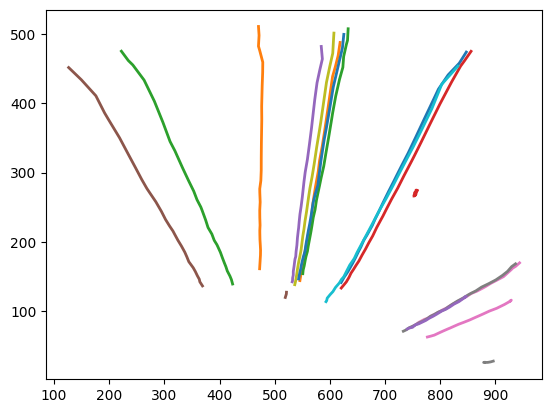

In [37]:
if history:
    fig, ax = plt.subplots()
    # print(history[1])
    # trajectory = np.array(history[1])
    # print(trajectory)
    # ax.plot(trajectory[:, 0], trajectory[:, 1], linewidth=2)
    numpy_history = []
    for track_id, points in history.items():
        points = np.array(points)
        if (track_id == 17):
            ax.plot(points[:, 0], points[:, 1], linewidth=2)
        numpy_history.append(points)
    # print(numpy_history)
    x_points = [point[:, 0] for point in numpy_history]
    y_points = [point[:, 1] for point in numpy_history]
    print(y_points)
    print(x_points)
    plt.savefig('output_plot.png')

id: 17, (30, 1), mean_squared_error: 12242.588763245458, r2_score: 0.03248773064839405


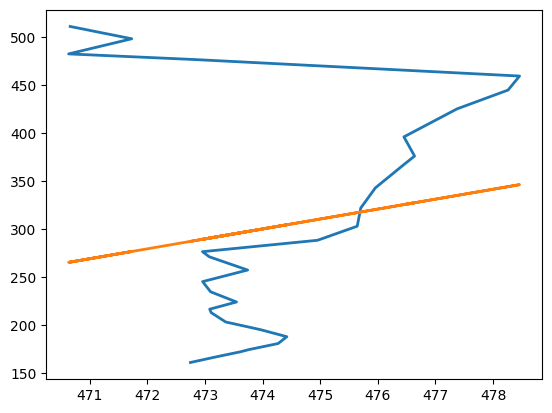

In [66]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

regression = linear_model.LinearRegression()
car_regressions = []
for i, (x, y) in enumerate(zip(x_points, y_points)):
    stats = {}
    x = x.reshape(-1, 1)
    regression.fit(x, y)
    y_pred = regression.predict(x)
    stats['mean_squared_error'] = mean_squared_error(y, y_pred)
    stats['r2_score'] = r2_score(y, y_pred)
    stats['x_vals'] = x
    stats['y_vals'] = y
    stats['y_pred'] = y_pred
    stats['id'] = i
    car_regressions.append(stats)
    # print(stats)

fig, ax = plt.subplots()
car_regressions.sort(key=lambda x: x['mean_squared_error'])
car_reg = car_regressions[-1]
print(f"id: {i}, {car_reg['x_vals'].shape}, mean_squared_error: {car_reg['mean_squared_error']}, r2_score: {car_reg['r2_score']}")
ax.plot(car_reg['x_vals'], car_reg['y_vals'], linewidth=2)
ax.plot(car_reg['x_vals'], car_reg['y_pred'], linewidth=2)

